## NLP stuff with Spotify User Reviews

Here we load, preprocess and explore Spotify user reviews to learn NLP preprocessing methods and gain first insights into the dataset.

In [1]:
## Import general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [39]:
## Read data
data_in = pd.read_csv("../data/raw/spotify_review_kaggle.csv")

In [40]:
## Check Data
data_in.head(10)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


In [41]:
## Sample some reviews
data_in["Review"].sample(20)

20371    It's good when you can put together all the so...
4826                 My goto music app, HQ bitrate needed.
512      This is a very good service for laptops and de...
28402    I could not love this app more! I use it every...
25477    It become more sad and unplayable because some...
45189               Very good streaming service for music.
52482    This app is absolutely terrible. I can't play ...
20600    This is more better then other apps because th...
47116    App was working well. Now I'm being asked to l...
10448    Good sound quality, collection ok but unfortun...
38925    Update has made ads play after every. Single. ...
55529    App used to be great and I never minded listen...
29899    Recently the app continues to crash while runn...
10543    Sign in nightmare. Lately it has asked for sig...
14675    The latest mobile update is so bad and annoyin...
1053      I cannot even listen to the music in my playlist
15474    Spotify is so much better than Amazon music yo.

In [43]:
## Remove duplicates
print("Before dropping duplicates: ", len(data_in))
data = data_in.drop_duplicates(subset="Review")
print("After dropping duplicates: ", len(data))


Before dropping duplicates:  61594
After dropping duplicates:  61356


In [47]:
## Drop unused cols
data = data[["Review", "Rating"]]
data.head(5)

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [65]:
## Ad col for reviews length
data["Length"] = data["Review"].str.split(" ").str.len()
data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",5,21
1,Please ignore previous negative rating. This a...,5,15
2,"This pop-up ""Get the best Spotify experience o...",4,19
3,Really buggy and terrible to use as of recently,1,9
4,Dear Spotify why do I get songs that I didn't ...,1,21


In [66]:
## Check shortest reviews
data.sort_values("Length").head(10)


,Review,Rating,Length
24628,Easy-to-use software,5,2
30670,"Powerful,Spirit-touching songs",5,2
27164,Best music service,5,3
4562,Always interrupts ads,1,3
4569,To many advertisement!!!,1,3
9923,Too much ads.,1,3
4572,Love no ads!,5,3
33635,Brilliant music app,5,3
9938,Full of adds,1,3
13112,Great and dynamic,5,3


In [74]:
## Check longest reviews
data.sort_values("Length").tail(20)


,Review,Rating,Length
21354,so i love spotify but as you see there is only...,4,112
13407,This app sucks because it adds song I don't wa...,1,112
45809,This app is like when u have to write a 1000 w...,4,113
12793,Hmm I don't know how much it meansJim I have R...,1,114
57928,"Spotify, a MUSIC STREAMING SERVICE chose Joe R...",1,119
12328,The app on a watch needs a lot of work. I down...,1,120
22771,So after the new update the app is still glitc...,1,121
58168,I clicked on the $0.99 for three months promot...,1,125
54164,"I love spotify, but now there seems to be a gl...",1,126
33014,Being a premium user for years I can say that ...,2,137


c:\Users\dominik.freunberger\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


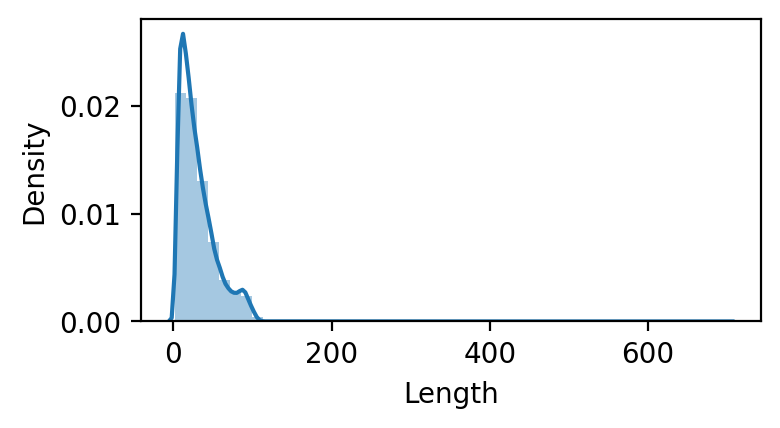

In [73]:
## Plot Review Length as hist
plt.figure(figsize=(4,2), dpi=200)
ax = sns.distplot(data["Length"]);

As we can see, most reviews are no longer than around 120 words; as a next step, we could remove all reviews with more than 150 words.

In [78]:
## Drop long reviews
data = data[data.Length < 150]

print("Number of reviews after trimming: ", len(data))

Number of reviews after trimming:  61346


### Preprocessing

In [85]:
## Import special libraries
import emojis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize as tokenizer

In [110]:
## Get NLTK english stopwords
our_stopwords = set(stopwords.words('english'))
